# Panini Monte Carlo Simulation

# Libraries

In [4]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
sns.set()

In [5]:
# Properties
n_stickers = 678
cost_per_packs = 1.1
pack_size = 5

## Album

In [19]:
class Album:
    '''
    Attributes
    ----------
    album : np.array of size n_stickers
        The value at index i determines the amount of stickers with this id are collected.
    album_complete : bool
        Turns to true as soon as the album is complete
    n_stickers : int
        Number of stickers in the album
    pack_size : int
        Size of a pack of stickers
    num_packs_bought : int
        The amount of packst that had to be bought until the album was complete
    
    
    Methods
    -------
    create_pack
        Creates a pack of uniformely distributed stickers
    buy_pack
        Simulates the buying process of on sticker pack and adds the sickers to the album
    fill_album
        Buys stickers until at least one of every sticker is in the album
    '''

    def __init__(self, n_stickers, pack_size):
        '''
        Parameters
        ----------
        n_stickers : int
            Number of stickers in the album
        pack_size : int
            Size of a pack of stickers
        '''
        
        self.n_stickers = n_stickers
        self.stickers = np.zeros(n_stickers)
        self.pack_size = pack_size
        self.num_packs_bought = 0
        self.album_complete = False
    
    def create_pack(self):
        '''
        Creates a sticker pack that contains n stickers defined by the pack size.
        The stickers are distributed uniformly

        Returns
        --------
        Numpy array
            Random selected stickers of size pack_size
        '''
        
        rng = np.random.default_rng()
        return(rng.integers(low=0, high=self.n_stickers, size=self.pack_size))

    
    def buy_pack(self):
        '''
        Simulates the buying process of on sticker pack.

        Creates a new sticker pack. The stickers that are contained inside this pack
        are then added to the album. The sticker number is the ID in the album. Thus, 1 is added
        to the album array at the index i=sticker_number.
        '''

        new_stickers = self.create_pack()
        for i in new_stickers:
            self.stickers[i] += 1

    
    def fill_album(self):
        '''
        Buys stickers until the album is full.
        '''
        # Check if album still contains zeros
        # if not -> buy new pack
        # if yes, stop
        while (self.stickers==0).any():
            self.buy_pack() 
            self.num_packs_bought += 1
                
        self.album_complete = True

            
def run_mc_simulation(n_simulations, n_stickers, pack_size):
    '''
    '''
    
    num_packs_fill_album = []
    albums = []
    for i in range(n_simulations):
        if i%100 == 0: print('Simulation Number: {}'.format(i))
        album = Album(n_stickers, pack_size)
        album.fill_album()
        num_packs_fill_album.append(album.num_packs_bought)
        albums.append(album.stickers)
        
    return albums, num_packs_fill_album

In [14]:
album = Album(n_stickers, pack_size)
album.fill_album()

In [16]:
album.stickers

array([ 5., 14.,  4., 13.,  7.,  4., 10.,  5., 13., 10.,  7.,  6.,  8.,
        6., 13.,  6.,  9.,  7., 10.,  5.,  8.,  9.,  7.,  9.,  3.,  7.,
        7.,  6., 13., 14., 12.,  6., 12., 11.,  8., 12., 15.,  6.,  8.,
       10.,  8., 12.,  7.,  7.,  6., 10.,  8.,  6.,  9., 11., 10., 12.,
        6.,  6.,  3., 12.,  9.,  5., 10.,  7., 11.,  9.,  7., 10., 11.,
        8.,  5., 15.,  7.,  6., 11.,  6.,  7.,  2., 10.,  7.,  7., 10.,
        7., 11.,  6., 12.,  5.,  8.,  7.,  6.,  5., 10.,  4.,  4.,  8.,
        9., 13.,  9., 12., 11., 12.,  6.,  5.,  6.,  8.,  4.,  5.,  7.,
        2.,  6.,  8., 10.,  5.,  7.,  9.,  7.,  7., 17., 10.,  6.,  6.,
        6., 10.,  7., 11., 15.,  9.,  8.,  6., 11.,  3.,  6., 11.,  8.,
       12.,  9.,  6., 12.,  5., 12.,  7., 12., 10.,  8.,  7., 11.,  7.,
       10., 10., 12., 13.,  8.,  6.,  9., 13.,  9., 11.,  9.,  7.,  9.,
        5.,  5.,  9.,  6.,  9.,  9.,  6., 11., 12.,  8., 11.,  9., 11.,
        6.,  9.,  9.,  7.,  7., 11., 11.,  5.,  9., 10., 14.,  9

In [4]:
album = np.zeros(n_stickers)
album, num_packs_buy = fill_album(album, n_stickers, pack_size)
print("Number of packs to fill the album: {}".format(num_packs_buy))

Number of packs to fill the album: 837


In [20]:
albums, num_packs_fill_album = run_mc_simulation(1000, n_stickers, pack_size)

Simulation Number: 0
Simulation Number: 100
Simulation Number: 200
Simulation Number: 300
Simulation Number: 400
Simulation Number: 500
Simulation Number: 600
Simulation Number: 700
Simulation Number: 800
Simulation Number: 900


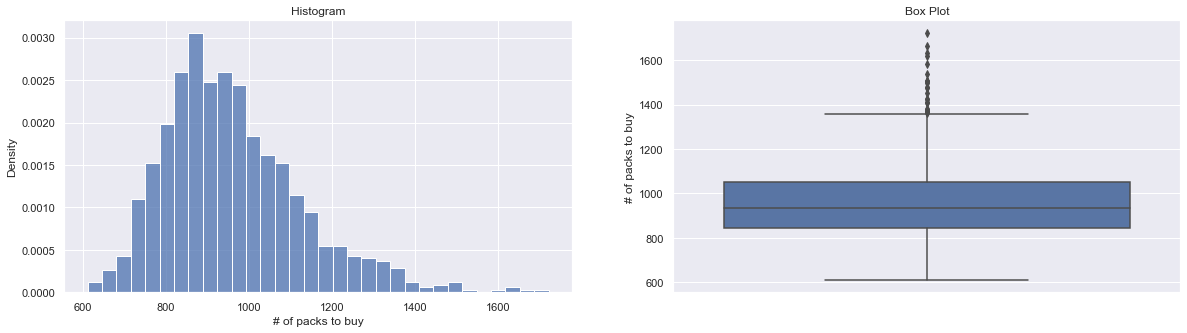

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(ax=axes[0], x=num_packs_fill_album,  bins='sqrt', stat='density');
axes[0].set(ylabel='Density', xlabel='# of packs to buy');
axes[0].set_title('Histogram')
#sns.violinplot(ax=axes[1], y=num_packs_fill_album);
#axes[1].set_title('Violin Plot')
#axes[1].set(ylabel='# of packs to buy');
sns.boxplot(ax=axes[1], y=num_packs_fill_album);
axes[1].set_title('Box Plot')
axes[1].set(ylabel='# of packs to buy');

fig.savefig('no_of_packs')

In [159]:
print('The mean number of packs one has to buy to fill the complete album is: {}'.format(np.mean(num_packs_fill_album)))
print('With a chance of 10%, you need less than {} packs to fill the album '.format(np.percentile(num_packs_fill_album, 10)))
print('With a chance of 10%, you need more than {} packs to fill the album '.format(np.percentile(num_packs_fill_album, 90)))


The mean number of packs one has to buy to fill the complete album is: 962.926
With a chance of 10%, you need less than 770.0 packs to fill the album 
With a chance of 10%, you need more than 1193.0 packs to fill the album 


## Evaluate the duplicates

In [143]:
duplicates = np.zeros(40) 
amount_of_duplicates = []
for album in albums:  
    amount_of_duplicates.append(np.sum(album) - n_stickers) 
    counts = np.bincount(np.int64(album))
    len_counts = len(counts)
    duplicates[0:len_counts] = duplicates[0:len_counts] + counts

In [171]:
print(np.median(amount_of_duplicates))
print('Theoretical amount of duplicates: {}'.format(np.mean(num_packs_fill_album)*pack_size - n_stickers))

print('With a chance of 10%, you will have less than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates, 80)))
print('With a chance of 10%, you will have more than than {} duplicates when completing the album '.format(np.percentile(amount_of_duplicates, 90)))


3987.0
Theoretical amount of duplicates: 4136.63
With a chance of 10%, you will have less than than 4762.0 duplicates when completing the album 
With a chance of 10%, you will have more than than 5287.0 duplicates when completing the album 


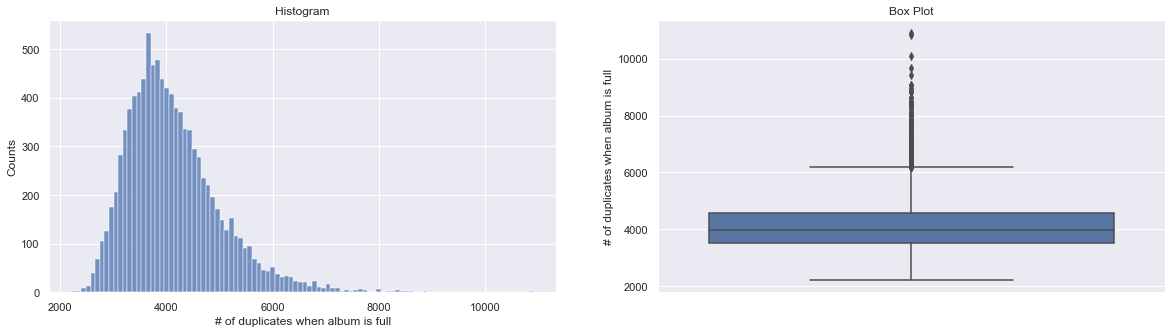

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(20,5));
sns.histplot(ax=axes[0], x=amount_of_duplicates,  bins='sqrt');
axes[0].set(ylabel='Counts', xlabel='# of duplicates when album is full');
axes[0].set_title('Histogram')
#sns.violinplot(ax=axes[1], y=amount_of_duplicates);
#axes[1].set_title('Violin Plot')
#axes[1].set(ylabel='# of duplicates when album is full');
sns.boxplot(ax=axes[1], y=amount_of_duplicates);
axes[1].set_title('Box Plot')
axes[1].set(ylabel='# of duplicates when album is full');
fig.savefig('img/no_swapping/no_of_duplicates')